In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tabulate import tabulate
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import shap

In [2]:
df = pd.read_csv('df_cleaned.csv')
df.head()

,age,income_level,fico_score,delinquency_status,charge_off_status,number_of_credit_applications,debt_to_income_ratio,payment_methods_high_risk,max_balance,avg_balance_last_12months,...,multiple_applications_short_time_period,unusual_submission_pattern,applications_submitted_during_odd_hours,watchlist_blacklist_flag,public_records_flag,location_encoded,occupation_encoded,days_since_recent_trade,time_between_account_open_and_trade,credit_history_length
0,56,40099,424.000000,108,1,10,3.139572,0,18209.383136,4324.930673,...,1,1,0,0,1,0.254848,0.256207,268,119,2004
1,69,2050,483.000000,0,0,1,1.017489,0,33673.696504,21726.593916,...,0,1,0,0,0,0.285933,0.266010,307,504,326
2,46,71936,566.000000,0,0,1,1.508626,0,101918.174202,63930.102255,...,0,0,0,0,0,0.264368,0.266010,58,1544,160
3,32,15833,491.513037,97,1,5,2.995150,0,9055.101659,3033.403742,...,0,1,1,0,0,0.241167,0.266965,47,62,396
4,60,8574,787.000000,0,0,1,1.182380,0,91682.852040,77457.387016,...,1,0,1,0,0,0.241167,0.221757,89,37,664


In [3]:
from sklearn.model_selection import train_test_split
X = df.drop('charge_off_status', axis=1)
y = df['charge_off_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [4]:
X_train_drop1 = X_train.drop(columns=["number_of_delinquent_accounts"])
X_test_drop1 = X_test.drop(columns=["number_of_delinquent_accounts"])

In [ ]:
np.random.seed(32)

iso_forest = IsolationForest(contamination=0.3, random_state=32)
outlier_labels_train = iso_forest.fit_predict(X_train_drop1)

X_outliers_train = X_train_drop1[outlier_labels_train == -1]
y_outliers_train = y_train[outlier_labels_train == -1]
X_regular_train = X_train_drop1[outlier_labels_train == 1]
y_regular_train = y_train[outlier_labels_train == 1]

outlier_labels_test = iso_forest.predict(X_test_drop1)
X_outliers_test = X_test_drop1[outlier_labels_test == -1]
y_outliers_test = y_test[outlier_labels_test == -1]
X_regular_test = X_test_drop1[outlier_labels_test == 1]
y_regular_test = y_test[outlier_labels_test == 1]

rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_outlier_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=32),
    rf_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
rf_outlier_search.fit(X_outliers_train, y_outliers_train)
rf_outlier = rf_outlier_search.best_estimator_

rf_regular_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=32),
    rf_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=32
)
rf_regular_search.fit(X_regular_train, y_regular_train)
rf_regular = rf_regular_search.best_estimator_

outlier_train_preds = rf_outlier.predict(X_outliers_train)
outlier_test_preds = rf_outlier.predict(X_outliers_test)
regular_train_preds = rf_regular.predict(X_regular_train)
regular_test_preds = rf_regular.predict(X_regular_test)

overall_test_preds = np.zeros(len(X_test), dtype=int)
overall_test_preds[outlier_labels_test == -1] = outlier_test_preds
overall_test_preds[outlier_labels_test == 1] = regular_test_preds

outlier_train_accuracy = accuracy_score(y_outliers_train, outlier_train_preds)
outlier_test_accuracy = accuracy_score(y_outliers_test, outlier_test_preds)
outlier_precision = precision_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_recall = recall_score(y_outliers_test, outlier_test_preds, average='weighted')
outlier_f1_macro = f1_score(y_outliers_test, outlier_test_preds, average='macro')
outlier_f1_weighted = f1_score(y_outliers_test, outlier_test_preds, average='weighted')

regular_train_accuracy = accuracy_score(y_regular_train, regular_train_preds)
regular_test_accuracy = accuracy_score(y_regular_test, regular_test_preds)
regular_precision = precision_score(y_regular_test, regular_test_preds, average='weighted')
regular_recall = recall_score(y_regular_test, regular_test_preds, average='weighted')
regular_f1_macro = f1_score(y_regular_test, regular_test_preds, average='macro')
regular_f1_weighted = f1_score(y_regular_test, regular_test_preds, average='weighted')

overall_accuracy = accuracy_score(y_test, overall_test_preds)
overall_precision = precision_score(y_test, overall_test_preds, average='weighted')
overall_recall = recall_score(y_test, overall_test_preds, average='weighted')
overall_f1_macro = f1_score(y_test, overall_test_preds, average='macro')
overall_f1_weighted = f1_score(y_test, overall_test_preds, average='weighted')

print("Evaluation metrics – outlier cluster:")
print(f"Outlier cluster - Train Accuracy: {outlier_train_accuracy}, Test Accuracy: {outlier_test_accuracy}")
print(f"Outlier cluster - Precision (weighted): {outlier_precision}, Recall (weighted): {outlier_recall}")
print(f"Outlier cluster - F1-Score (macro): {outlier_f1_macro}, F1-Score (weighted): {outlier_f1_weighted}")

print("\nEvaluation metrics – regular observations cluster:")
print(f"Regular observations cluster - Train Accuracy: {regular_train_accuracy}, Test Accuracy: {regular_test_accuracy}")
print(f"Regular observations cluster - Precision (weighted): {regular_precision}, Recall (weighted): {regular_recall}")
print(f"Regular observations cluster - F1-Score (macro): {regular_f1_macro}, F1-Score (weighted): {regular_f1_weighted}")

print("\nOverall evaluation metrics:")
print(f"Overall - Accuracy: {overall_accuracy}")
print(f"Overall - Precision (weighted): {overall_precision}, Recall (weighted): {overall_recall}")
print(f"Overall - F1-Score (macro): {overall_f1_macro}, F1-Score (weighted): {overall_f1_weighted}")

Evaluation metrics – outlier cluster:
Outlier cluster - Train Accuracy: 0.8607142857142858, Test Accuracy: 0.8167053364269141
Outlier cluster - Precision (weighted): 0.8252785417083561, Recall (weighted): 0.8167053364269141
Outlier cluster - F1-Score (macro): 0.8058303917151868, F1-Score (weighted): 0.812120800911186

Evaluation metrics – regular observations cluster:
Regular observations cluster - Train Accuracy: 0.8969387755102041, Test Accuracy: 0.891640866873065
Regular observations cluster - Precision (weighted): 0.8868352297468715, Recall (weighted): 0.891640866873065
Regular observations cluster - F1-Score (macro): 0.5576246646695392, F1-Score (weighted): 0.8515747903617158

Overall evaluation metrics:
Overall - Accuracy: 0.8685714285714285
Overall - Precision (weighted): 0.8644616217098601, Recall (weighted): 0.8685714285714285
Overall - F1-Score (macro): 0.817615406400453, F1-Score (weighted): 0.8645775781850549


In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, overall_test_preds)
tp, fp, fn, tn = cm.ravel()

#postive predictive value
ppv = tp / (tp + fp)
print("Postive predictive value:", ppv)

#negative predictive value
npv = tn / (tn + fn)
print("Negative predictive value:", npv)

Postive predictive value: 0.9394812680115274
Negative predictive value: 0.6629526462395543


Overall Feature Importances:
                                    Feature  Importance
3                        delinquency_status    0.232263
4             number_of_credit_applications    0.101746
8                 avg_balance_last_12months    0.089051
2                                fico_score    0.070917
7                               max_balance    0.066385
19      time_between_account_open_and_trade    0.061711
5                      debt_to_income_ratio    0.053118
20                    credit_history_length    0.045585
18                  days_since_recent_trade    0.043874
1                              income_level    0.043715
0                                       age    0.032801
9              number_of_defaulted_accounts    0.031654
16                         location_encoded    0.031248
10        new_accounts_opened_last_12months    0.029133
17                       occupation_encoded    0.022698
6                 payment_methods_high_risk    0.014024
12               un

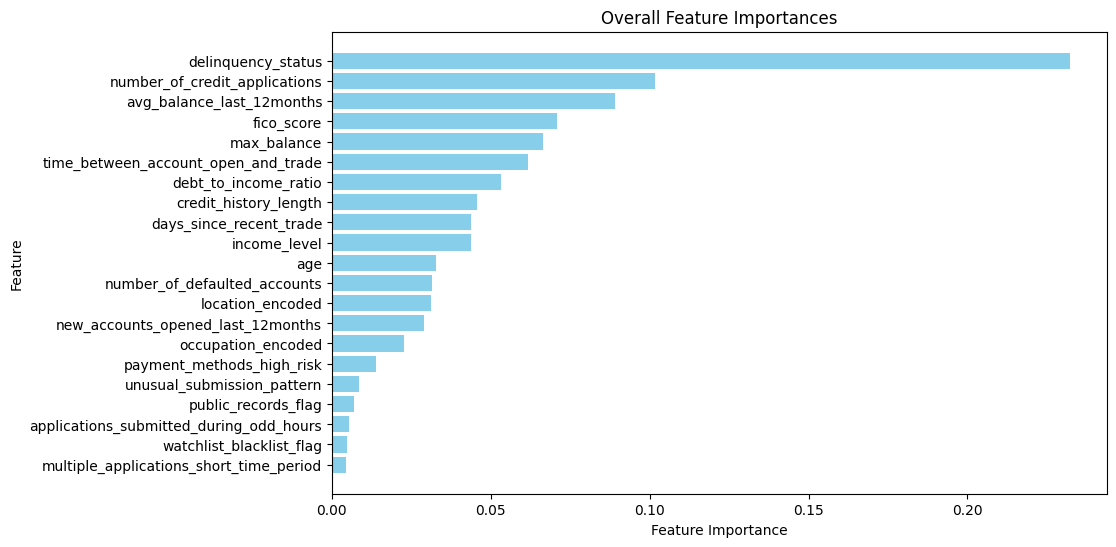

In [ ]:
#feature importances
outlier_feature_importances = rf_outlier.feature_importances_
regular_feature_importances = rf_regular.feature_importances_

overall_feature_importances = (outlier_feature_importances + regular_feature_importances) / 2

feature_names = X_train_drop1.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(len(overall_feature_importances))]
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": overall_feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print("Overall Feature Importances:")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Overall Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [5]:
rf_overall = RandomForestClassifier(n_estimators=100, max_depth=5, max_features='sqrt', min_samples_leaf=1, min_samples_split=3, random_state=32)
rf_overall.fit(X_train_drop1,y_train)

RandomForestClassifier(max_depth=5, min_samples_split=3, random_state=32)

In [ ]:
explainer = shap.TreeExplainer(rf_overall)
shap_values = explainer.shap_values(X_test_drop1)
shap_values_class_1 = shap_values[:, :, 1]
shap_values_class_0 = shap_values[:, :, 0]

mean_shap_values_class_1 = np.abs(shap_values_class_1).mean(axis=0)
mean_shap_values_class_0 = np.abs(shap_values_class_0).mean(axis=0)

top_10_features_idx_class_1 = np.argsort(mean_shap_values_class_1)[-10:]
top_10_features_idx_class_0 = np.argsort(mean_shap_values_class_0)[-10:]

X_test_top10_class_1 = X_test_drop1.iloc[:, top_10_features_idx_class_1]
shap_values_top10_class_1 = shap_values_class_1[:, top_10_features_idx_class_1]

X_test_top10_class_0 = X_test_drop1.iloc[:, top_10_features_idx_class_0]
shap_values_top10_class_0 = shap_values_class_0[:, top_10_features_idx_class_0]

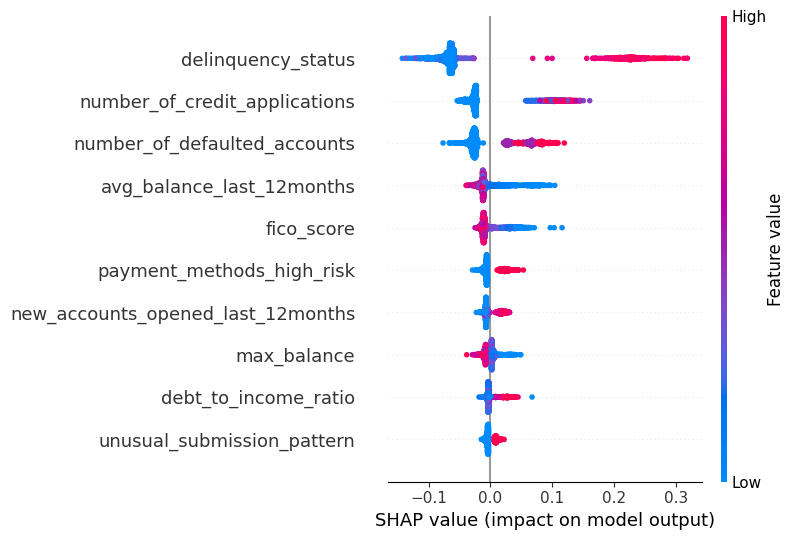

In [ ]:
shap.summary_plot(shap_values_top10_class_1, X_test_top10_class_1)

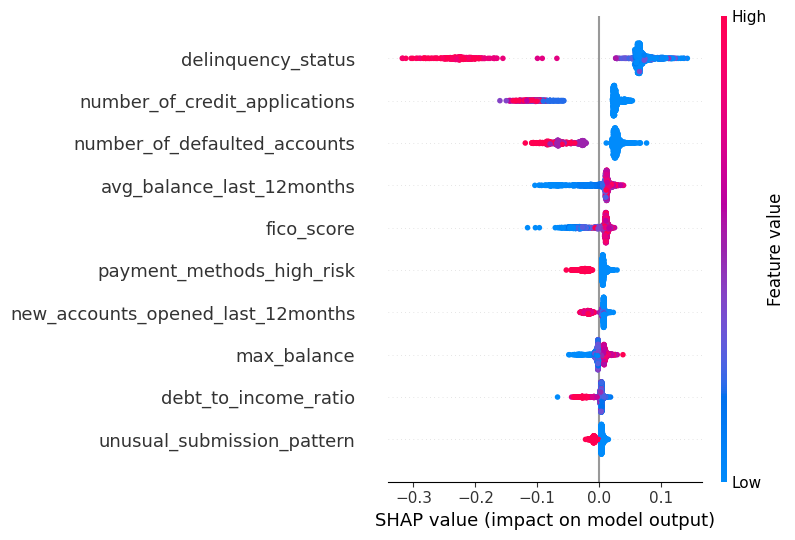

In [ ]:
shap.summary_plot(shap_values_top10_class_0, X_test_top10_class_0)

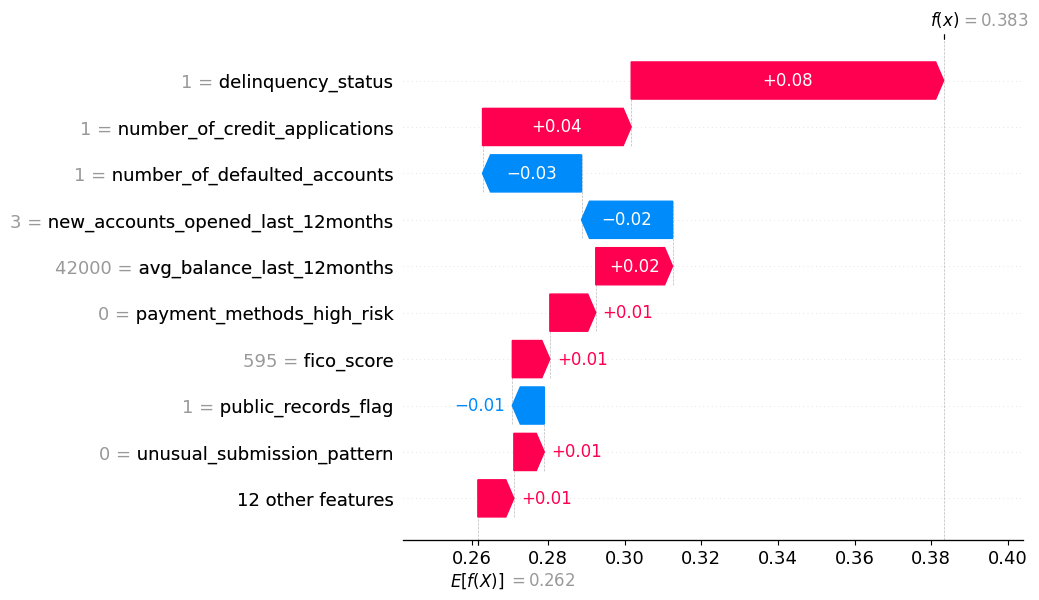

In [ ]:
#shap plot for new observation
new_observation = pd.DataFrame({
    'age': [42],  'income_level': [50000],
    'fico_score': [595],  'delinquency_status': [1],
    'number_of_credit_applications': [1],  'debt_to_income_ratio': [0.64],
    'payment_methods_high_risk': [0],  'max_balance': [45000],
    'avg_balance_last_12months': [42000],  'number_of_defaulted_accounts': [1],
    'new_accounts_opened_last_12months': [3],
    'multiple_applications_short_time_period': [0],  'unusual_submission_pattern': [0],
    'applications_submitted_during_odd_hours': [0],  'watchlist_blacklist_flag': [0],
    'public_records_flag': [1],  'location_encoded': [0.2],
    'occupation_encoded': [0.2],  'days_since_recent_trade': [230],
    'time_between_account_open_and_trade': [1320],  'credit_history_length': [600]
})

new_observation = new_observation[X_train_drop1.columns]

#SHAP values for the new observation
explainer = shap.TreeExplainer(rf_overall)
shap_values = explainer.shap_values(new_observation)

shap_values_class_1 = shap_values_class_1 = shap_values[:, :, 1]
shap_values_class_0 = shap_values_class_1 = shap_values[:, :, 0]

shap_values_explanation = shap.Explanation(
    values=shap_values_class_1,
    base_values=explainer.expected_value[1],
    data=new_observation.values,
    feature_names=X_train_drop1.columns
)
shap.waterfall_plot(shap_values_explanation[0])

In [ ]:
#model with only top 10 features

top_10_features = importance_df["Feature"].head(10).values

X_outliers_train_top10 = X_outliers_train[top_10_features]
X_regular_train_top10 = X_regular_train[top_10_features]
X_outliers_test_top10 = X_outliers_test[top_10_features]
X_regular_test_top10 = X_regular_test[top_10_features]

rf_outlier_top10 = rf_outlier
rf_regular_top10 = rf_regular

rf_outlier_top10.fit(X_outliers_train_top10, y_outliers_train)
rf_regular_top10.fit(X_regular_train_top10, y_regular_train)

outlier_test_preds_top10 = rf_outlier_top10.predict(X_outliers_test_top10)
outlier_test_accuracy_top10 = accuracy_score(y_outliers_test, outlier_test_preds_top10)
outlier_precision_top10 = precision_score(y_outliers_test, outlier_test_preds_top10, average='weighted')
outlier_recall_top10 = recall_score(y_outliers_test, outlier_test_preds_top10, average='weighted')
outlier_f1_top10 = f1_score(y_outliers_test, outlier_test_preds_top10, average='weighted')

regular_test_preds_top10 = rf_regular_top10.predict(X_regular_test_top10)
regular_test_accuracy_top10 = accuracy_score(y_regular_test, regular_test_preds_top10)
regular_precision_top10 = precision_score(y_regular_test, regular_test_preds_top10, average='weighted')
regular_recall_top10 = recall_score(y_regular_test, regular_test_preds_top10, average='weighted')
regular_f1_top10 = f1_score(y_regular_test, regular_test_preds_top10, average='weighted')

overall_test_preds_top10 = np.zeros(len(X_test), dtype=int)
overall_test_preds_top10[outlier_labels_test == -1] = outlier_test_preds_top10
overall_test_preds_top10[outlier_labels_test == 1] = regular_test_preds_top10

overall_accuracy_top10 = accuracy_score(y_test, overall_test_preds_top10)
overall_precision_top10 = precision_score(y_test, overall_test_preds_top10, average='weighted')
overall_recall_top10 = recall_score(y_test, overall_test_preds_top10, average='weighted')
overall_f1_top10 = f1_score(y_test, overall_test_preds_top10, average='weighted')

print("Evaluation metrics with Top 10 Features:")
print(f"Outlier cluster - Test Accuracy: {outlier_test_accuracy_top10}")
print(f"Outlier cluster - Precision: {outlier_precision_top10}, Recall: {outlier_recall_top10}, F1-Score: {outlier_f1_top10}")
print(f"Regular observations cluster - Test Accuracy: {regular_test_accuracy_top10}")
print(f"Regular observations cluster - Precision: {regular_precision_top10}, Recall: {regular_recall_top10}, F1-Score: {regular_f1_top10}")
print(f"Overall - Accuracy: {overall_accuracy_top10}, Precision: {overall_precision_top10}, Recall: {overall_recall_top10}, F1-Score: {overall_f1_top10}")

Evaluation metrics with Top 10 Features:
Outlier cluster - Test Accuracy: 0.814385150812065
Outlier cluster - Precision: 0.822239356384283, Recall: 0.814385150812065, F1-Score: 0.8099001987144617
Regular observations cluster - Test Accuracy: 0.8885448916408669
Regular observations cluster - Precision: 0.8702978573628405, Recall: 0.8885448916408669, F1-Score: 0.8480866103347415
Overall - Accuracy: 0.8657142857142858, Precision: 0.8614045991674703, Recall: 0.8657142857142858, F1-Score: 0.8616336124934254


## Credit Score Prediction

In [ ]:
def probability_to_score(prob_default):
    return 1000 * (1 - prob_default) + 1

In [ ]:
outlier_train_probs = rf_outlier.predict_proba(X_outliers_train)[:, 1]
outlier_test_probs = rf_outlier.predict_proba(X_outliers_test)[:, 1]
regular_train_probs = rf_regular.predict_proba(X_regular_train)[:, 1]
regular_test_probs = rf_regular.predict_proba(X_regular_test)[:, 1]

outlier_train_scores = probability_to_score(outlier_train_probs)
outlier_test_scores = probability_to_score(outlier_test_probs)
regular_train_scores = probability_to_score(regular_train_probs)
regular_test_scores = probability_to_score(regular_test_probs)

overall_test_scores = np.zeros(len(X_test), dtype=float)
overall_test_scores[outlier_labels_test == -1] = outlier_test_scores
overall_test_scores[outlier_labels_test == 1] = regular_test_scores

In [ ]:
print("Example Credit Scores:")
for i in range(5):
    print(f"Credit Score (Overall): {overall_test_scores[i]:.2f}")

Example Credit Scores:
Credit Score (Overall): 798.39
Credit Score (Overall): 187.24
Credit Score (Overall): 304.04
Credit Score (Overall): 911.77
Credit Score (Overall): 918.14


In [11]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import pickle
from sklearn import preprocessing

**Encoding categorical columns in model**


In [12]:
categorical_cols_index = [7, 13, 14, 15, 16, 17, 18, 19]
category_col = df.columns[categorical_cols_index]
lbl_data = df.copy()
df_input = df[category_col].copy()
encoder = preprocessing.LabelEncoder()
encoder_dict = dict()
for cat in category_col:
    df_input[cat] = df_input[cat].fillna('').astype(str)
    df_input[cat] = df_input[cat].str.lstrip()
    encoder = encoder.fit(list(df_input[cat]) + ['Unknown'])
    encoder_dict[cat] = [cat for cat in encoder.classes_]
    lbl_data[cat] = encoder.transform(df_input[cat])

In [13]:
lbl_data.head()

,age,income_level,fico_score,delinquency_status,charge_off_status,number_of_credit_applications,debt_to_income_ratio,payment_methods_high_risk,max_balance,avg_balance_last_12months,...,multiple_applications_short_time_period,unusual_submission_pattern,applications_submitted_during_odd_hours,watchlist_blacklist_flag,public_records_flag,location_encoded,occupation_encoded,days_since_recent_trade,time_between_account_open_and_trade,credit_history_length
0,56,40099,424.000000,108,1,10,3.139572,0,18209.383136,4324.930673,...,1,1,0,0,1,3,3,268,119,2004
1,69,2050,483.000000,0,0,1,1.017489,0,33673.696504,21726.593916,...,0,1,0,0,0,9,6,307,504,326
2,46,71936,566.000000,0,0,1,1.508626,0,101918.174202,63930.102255,...,0,0,0,0,0,6,6,58,1544,160
3,32,15833,491.513037,97,1,5,2.995150,0,9055.101659,3033.403742,...,0,1,1,0,0,0,7,47,62,396
4,60,8574,787.000000,0,0,1,1.182380,0,91682.852040,77457.387016,...,1,0,1,0,0,0,0,89,37,664


In [14]:
print(encoder_dict)

{'payment_methods_high_risk': ['0', '1', 'Unknown'], 'multiple_applications_short_time_period': ['0', '1', 'Unknown'], 'unusual_submission_pattern': ['0', '1', 'Unknown'], 'applications_submitted_during_odd_hours': ['0', '1', 'Unknown'], 'watchlist_blacklist_flag': ['0', '1', 'Unknown'], 'public_records_flag': ['0', '1', 'Unknown'], 'location_encoded': ['0.2411674347158218', '0.2461752433936022', '0.2465373961218836', '0.2548476454293629', '0.2577030812324929', '0.264069264069264', '0.264367816091954', '0.2649930264993027', '0.2851123595505618', '0.2859327217125382', 'Unknown'], 'occupation_encoded': ['0.2217573221757322', '0.2313829787234042', '0.2447257383966244', '0.2562065541211519', '0.2590551181102362', '0.2617283950617284', '0.2660098522167488', '0.2669649515287099', '0.2694475760992108', '0.2721712538226299', '0.2808398950131233', 'Unknown']}


In [16]:
#save label encoder
encoder_pickle_out = open("encoder.pkl", "wb")
pickle.dump(encoder_dict, encoder_pickle_out)
encoder_pickle_out.close()

In [17]:
#save model
pickle_out = open("model.pkl", "wb")
pickle.dump(rf_overall, pickle_out)
pickle_out.close()

In [18]:
with open('model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

print(type(loaded_model))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [19]:
#test model
pkl_file = open('encoder.pkl', 'rb')
encoder_dict = pickle.load(pkl_file)
pkl_file.close()

df2 = pd.DataFrame({
    'age': [42],  'income_level': [50000],
    'fico_score': [595],  'delinquency_status': [1],
    'number_of_credit_applications': [1],  'debt_to_income_ratio': [0.64],
    'payment_methods_high_risk': [0],  'max_balance': [45000],
    'avg_balance_last_12months': [42000],  'number_of_defaulted_accounts': [1],
    'new_accounts_opened_last_12months': [3],
    'multiple_applications_short_time_period': [0],  'unusual_submission_pattern': [0],
    'applications_submitted_during_odd_hours': [0],  'watchlist_blacklist_flag': [0],
    'public_records_flag': [1],  'location_encoded': [0.2],
    'occupation_encoded': [0.2],  'days_since_recent_trade': [230],
    'time_between_account_open_and_trade': [1320],  'credit_history_length': [600]
})
df2.head()

,age,income_level,fico_score,delinquency_status,number_of_credit_applications,debt_to_income_ratio,payment_methods_high_risk,max_balance,avg_balance_last_12months,number_of_defaulted_accounts,...,multiple_applications_short_time_period,unusual_submission_pattern,applications_submitted_during_odd_hours,watchlist_blacklist_flag,public_records_flag,location_encoded,occupation_encoded,days_since_recent_trade,time_between_account_open_and_trade,credit_history_length
0,42,50000,595,1,1,0.64,0,45000,42000,1,...,0,0,0,0,1,0.2,0.2,230,1320,600


In [22]:
for cat in encoder_dict:
    for col in df2.columns:
        le = preprocessing.LabelEncoder()
        if cat == col:
            le.classes_ = encoder_dict[cat]
            for unique_item in df2[col].unique():
                if unique_item not in le.classes_:
                    df2[col] = df2[col].apply(lambda x: x if x in le.classes_ else 'Unknown')
            le.fit(df2[col])
            df2[col] = le.transform(df2[col])

features_list = df2.values.tolist()
fraud_prediction = rf_overall.predict(features_list)  #fraud prediction
fraud_probabilities = rf_overall.predict_proba(features_list)

#credit risk score (between 1 and 1000)
credit_risk_score = (fraud_probabilities[:, 1] * 999) + 1

print("Fraud Prediction:", fraud_prediction[0])
print("Credit Risk Score:", credit_risk_score[0])

Fraud Prediction: 0
Credit Risk Score: 133.34305535019897
